# Distributing Seismic Processing with On-Demand Computing

This is a workflow where we will work through performing calculations on post-stack seismic data using cloud computing.  

We will use this Jupyter notebook to walk through the steps (the only provisioned resource used), S3 to store the data, and Lambda to do the processing.

The seismic data is streamed from S3 without the need to duplicate any portion of it.  This is ideal for situations where you need to work with large (+100GB) SEGY files that cannot always be loaded into memory and to also avoid the cost of making a duplicate on a local filesystem.  Lambda will allow you to parallel process the data at low cost and with no need to provision hardware.

### Import packages

First, lets import all the packages we will need.  Notice that all packages are native to SageMaker and we do not need to install anything.

In [1]:
import sys
import time
import json
import boto3
import struct
import pickle
import botocore
import array as arr
import numpy as np
import matplotlib.pyplot as plt
from struct import Struct

### Load SEGY
We will load the SEGY file from S3 and create a StreamingBody object we can use to stream data into the notebook.  We do not need to copy the file locally.  

No need to modify these variables if working in the US-East-1 region.  

In [2]:
source_bucket   = 'equinor-volve-data-village'    # S3 bucket name with input data
source_folder   = 'Seismic/ST0202/Stacks'         # Folder path, sometimes referred to as the prefix
source_filename = 'ST0202R08_PZ_PSDM_FULL_OFFSET_DEPTH.MIG_FIN.POST_STACK.3D.JS-017534.segy' # Filename

# Get the file stream
s3 = boto3.resource('s3')
segy_obj = s3.Object(source_bucket, f"{source_folder}/{source_filename}")
segy_stream = segy_obj.get()['Body']

### Read Headers
Lets read the text and binary headers of the SEGY file.  We are assuming the file follows the SEGY Rev1 standard.

In this format, the first 3200 bytes are the text header, the next 400 are the binary headers.

In [3]:
text_header_raw = segy_stream.read(3200)
bin_header_raw = segy_stream.read(400)

Lets take a look at the text headers.  Headers are in cp500/ebcdic encoding. Here are the first 100 bytes in a raw format.

In [4]:
print(text_header_raw[:100])

b'\xc3@\xf1@\xc3\xd3\xc9\xc5\xd5\xe3~\xe2\xe3\xc1\xe3\xd6\xc9\xd3k@@@@@@\xd7\xd9\xd6\xc3\xc5\xe2\xe2\xc5\xc4@\xc2\xe8~\xe6\xc5\xe2\xe3\xc5\xd9\xd5\xc7\xc5\xc3\xd6@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@\xc3@\xf2@\xd3\xc9\xd5\xc5@\xe2\xe3\xf0\xf2\xf0\xf2\xc4\xf0\xf4`\xf9'


Lets decode it and make it more presentable.  It will be useful to see if there are any notes mentioning if the binary headers are stored in the correct byte locations. 

In [5]:
def DecodeTextHeader(text_header_raw):
    text_header = text_header_raw.decode('cp500')
    text_header = text_header.replace("C 1 ", "\nC 1 ")
    text_header = text_header.replace("C 2 ", "\nC 2 ")
    text_header = text_header.replace("C 3 ", "\nC 3 ")
    text_header = text_header.replace("C 4 ", "\nC 4 ")
    text_header = text_header.replace("C 5 ", "\nC 5 ")
    text_header = text_header.replace("C 6 ", "\nC 6 ")
    text_header = text_header.replace("C 7 ", "\nC 7 ")
    text_header = text_header.replace("C 8 ", "\nC 8 ")
    text_header = text_header.replace("C 9 ", "\nC 9 ")
    text_header = text_header.replace("C10 ", "\nC10 ")
    text_header = text_header.replace("C11 ", "\nC11 ")
    text_header = text_header.replace("C12 ", "\nC12 ")
    text_header = text_header.replace("C13 ", "\nC13 ")
    text_header = text_header.replace("C14 ", "\nC14 ")
    text_header = text_header.replace("C15 ", "\nC15 ")
    text_header = text_header.replace("C16 ", "\nC16 ")
    text_header = text_header.replace("C17 ", "\nC17 ")
    text_header = text_header.replace("C18 ", "\nC18 ")
    text_header = text_header.replace("C19 ", "\nC19 ")
    text_header = text_header.replace("C20 ", "\nC20 ")
    text_header = text_header.replace("C21 ", "\nC21 ")
    text_header = text_header.replace("C22 ", "\nC22 ")
    text_header = text_header.replace("C23 ", "\nC23 ")
    text_header = text_header.replace("C24 ", "\nC24 ")
    text_header = text_header.replace("C25 ", "\nC25 ")
    text_header = text_header.replace("C26 ", "\nC26 ")
    text_header = text_header.replace("C27 ", "\nC27 ")
    text_header = text_header.replace("C28 ", "\nC28 ")
    text_header = text_header.replace("C29 ", "\nC29 ")
    text_header = text_header.replace("C30 ", "\nC30 ")
    text_header = text_header.replace("C31 ", "\nC31 ")
    text_header = text_header.replace("C32 ", "\nC32 ")
    text_header = text_header.replace("C33 ", "\nC33 ")
    text_header = text_header.replace("C34 ", "\nC34 ")
    text_header = text_header.replace("C35 ", "\nC35 ")
    text_header = text_header.replace("C36 ", "\nC36 ")
    text_header = text_header.replace("C37 ", "\nC37 ")
    text_header = text_header.replace("C38 ", "\nC38 ")
    text_header = text_header.replace("C39 ", "\nC39 ")
    text_header = text_header.replace("C40 ", "\nC40 ")
    
    return text_header

text_header = DecodeTextHeader(text_header_raw)

print(text_header)


C 1 CLIENT=STATOIL,      PROCESSED BY=WESTERNGECO                               
C 2 LINE ST0202D04-9985                                                         
C 3 SURVEY:ST0202 ,   AREA: VOLVE 15/9                                          
C 4 DATAFORMAT: SEG-Y,     DATE:27122007                                        
C 5 DATATYPE: FINAL PZ PSDM STACK FULL OFFSET IN DEPTH                          
C 6 DATA SHOT BY/VESSEL:GECO ANGLER,  CABLE LENGTH:6000 M  NO OF GROUPS: 240x4  
C 7 NO OF CABLES 2,      SOURCE:2,  POP INTERVAL 25.0 M (FLIP-FLOP)             
C 8 RCV LINE SPACING: 400 M,    SRC LINE SPACING: 100 M, RECORD LENGTH: 10.2 S  
C 9 GEODETIC DATUM: ED-50,      SPHEROID: INTERNAT., PROJECTION: UTM            
C10 CENTR. MERID.: 03,          UTM ZONE: 31 N, FALSE EASTING: 500000           
C11 FIRST SAMPLE= 0,            LAST SAMPLE= 4500, SAMPLE INTERVAL= 5 M         
C12 DIST. BETWEEN INLINES=12.5M, XLINES=12.5M BIN SIZE (I x X):12.5M x 12.5M    
C13 INLINE DIRECTION (GRID)

Lets take a look at the binary header; it is raw bytes and needs to be decoded too.

In [6]:
print(bin_header_raw[:100])

b"\x00\x00\x00\x00\x00\x00'\x01\x00\x00\x00\x00\x00\x01\x00\x00\x13\x88\x00\x00\x03\x85\x00\x00\x00\x01\x00d\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00"


Now lets parse all the fields and assign them to the correct variables.  We need to convert bytes to integers, using big-endian byte order.  Most fields are 2 or 4 bytes.  This is assuming the SEGY file follows the rev1 standards correctly, which is not always the case.

In [7]:
# Function for decoding the binary headers.
def DecodeBinHeader(bin_header_raw):
    bin_header = {}

    bin_header['job_id']                  = int.from_bytes(bin_header_raw[0:4], byteorder='big', signed=False)
    bin_header['line_no']                 = int.from_bytes(bin_header_raw[4:8], byteorder='big', signed=False)
    bin_header['reel_no']                 = int.from_bytes(bin_header_raw[8:12], byteorder='big', signed=False)
    bin_header['data_traces']             = int.from_bytes(bin_header_raw[12:14], byteorder='big', signed=False)
    bin_header['aux_traces']              = int.from_bytes(bin_header_raw[14:16], byteorder='big', signed=False)
    bin_header['sample_interval']         = int.from_bytes(bin_header_raw[16:18], byteorder='big', signed=False)
    bin_header['sample_interval_orig']    = int.from_bytes(bin_header_raw[18:20], byteorder='big', signed=False)
    bin_header['samples_per_trace']       = int.from_bytes(bin_header_raw[20:22], byteorder='big', signed=False)
    bin_header['samples_per_trace_orig']  = int.from_bytes(bin_header_raw[22:24], byteorder='big', signed=False)
    bin_header['data_sample_format']      = int.from_bytes(bin_header_raw[24:26], byteorder='big', signed=False)
    bin_header['ensemble_fold']           = int.from_bytes(bin_header_raw[26:28], byteorder='big', signed=False)
    bin_header['trace_sorting']           = int.from_bytes(bin_header_raw[28:30], byteorder='big', signed=False)
    bin_header['vert_sum_code']           = int.from_bytes(bin_header_raw[30:32], byteorder='big', signed=False)
    bin_header['sweep_hz_start']          = int.from_bytes(bin_header_raw[32:34], byteorder='big', signed=False)
    bin_header['sweep_hz_end']            = int.from_bytes(bin_header_raw[34:36], byteorder='big', signed=False)
    bin_header['sweep_length']            = int.from_bytes(bin_header_raw[36:38], byteorder='big', signed=False)
    bin_header['sweep_type']              = int.from_bytes(bin_header_raw[38:40], byteorder='big', signed=False)
    bin_header['sweep_trace_ch']          = int.from_bytes(bin_header_raw[40:42], byteorder='big', signed=False)
    bin_header['sweep_trace_taper_start'] = int.from_bytes(bin_header_raw[42:44], byteorder='big', signed=False)
    bin_header['sweep_trace_taper_end']   = int.from_bytes(bin_header_raw[44:46], byteorder='big', signed=False)
    bin_header['taper_type']              = int.from_bytes(bin_header_raw[46:48], byteorder='big', signed=False)
    bin_header['data_traces_correlated']  = int.from_bytes(bin_header_raw[48:50], byteorder='big', signed=False)
    bin_header['binary_gain_recovered']   = int.from_bytes(bin_header_raw[50:52], byteorder='big', signed=False)
    bin_header['amp_recovery_method']     = int.from_bytes(bin_header_raw[52:54], byteorder='big', signed=False)
    bin_header['measurement_system']      = int.from_bytes(bin_header_raw[54:56], byteorder='big', signed=False)
    bin_header['impulse_sig_polarity']    = int.from_bytes(bin_header_raw[56:58], byteorder='big', signed=False)
    bin_header['vib_polarity']            = int.from_bytes(bin_header_raw[58:60], byteorder='big', signed=False)
    bin_header['unassigned']              = int.from_bytes(bin_header_raw[60:300], byteorder='big', signed=False)
    bin_header['segy_format']             = int.from_bytes(bin_header_raw[300:302], byteorder='big', signed=False)
    bin_header['fixed_length_flag']       = int.from_bytes(bin_header_raw[302:304], byteorder='big', signed=False)
    bin_header['extended_text_header_no'] = int.from_bytes(bin_header_raw[304:306], byteorder='big', signed=False)
    bin_header['unassigned2']             = int.from_bytes(bin_header_raw[306:400], byteorder='big', signed=False)
    
    return bin_header

# Function for printing the binary headers.
def PrintBinHeader(bin_header):
    print("job_id                  = ", bin_header['job_id']                 )
    print("line_no                 = ", bin_header['line_no']                )
    print("reel_no                 = ", bin_header['reel_no']                )
    print("data_traces             = ", bin_header['data_traces']            )
    print("aux_traces              = ", bin_header['aux_traces']             )
    print("sample_interval         = ", bin_header['sample_interval']        )
    print("sample_interval_orig    = ", bin_header['sample_interval_orig']   )
    print("samples_per_trace       = ", bin_header['samples_per_trace']      )
    print("samples_per_trace_orig  = ", bin_header['samples_per_trace_orig'] )
    print("data_sample_format      = ", bin_header['data_sample_format']     )
    print("ensemble_fold           = ", bin_header['ensemble_fold']          )
    print("trace_sorting           = ", bin_header['trace_sorting']          )
    print("vert_sum_code           = ", bin_header['vert_sum_code']          )
    print("sweep_hz_start          = ", bin_header['sweep_hz_start']         )
    print("sweep_hz_end            = ", bin_header['sweep_hz_end']           )
    print("sweep_length            = ", bin_header['sweep_length']           )
    print("sweep_type              = ", bin_header['sweep_type']             )
    print("sweep_trace_ch          = ", bin_header['sweep_trace_ch']         )
    print("sweep_trace_taper_start = ", bin_header['sweep_trace_taper_start'])
    print("sweep_trace_taper_end   = ", bin_header['sweep_trace_taper_end']  )
    print("taper_type              = ", bin_header['taper_type']             )
    print("data_traces_correlated  = ", bin_header['data_traces_correlated'] )
    print("binary_gain_recovered   = ", bin_header['binary_gain_recovered']  )
    print("amp_recovery_method     = ", bin_header['amp_recovery_method']    )
    print("measurement_system      = ", bin_header['measurement_system']     )
    print("impulse_sig_polarity    = ", bin_header['impulse_sig_polarity']   )
    print("vib_polarity            = ", bin_header['vib_polarity']           )
    print("unassigned              = ", bin_header['unassigned']             )
    print("segy_format             = ", bin(bin_header['segy_format'])[2:]   ) # Refer to SEGY standard on how to read this 
    print("fixed_length_flag       = ", bin_header['fixed_length_flag']      )
    print("extended_text_header_no = ", bin_header['extended_text_header_no'])
    print("unassigned2             = ", bin_header['unassigned2']            )
    
bin_header = DecodeBinHeader(bin_header_raw)
PrintBinHeader(bin_header)

job_id                  =  0
line_no                 =  9985
reel_no                 =  0
data_traces             =  1
aux_traces              =  0
sample_interval         =  5000
sample_interval_orig    =  0
samples_per_trace       =  901
samples_per_trace_orig  =  0
data_sample_format      =  1
ensemble_fold           =  100
trace_sorting           =  0
vert_sum_code           =  1
sweep_hz_start          =  0
sweep_hz_end            =  0
sweep_length            =  0
sweep_type              =  0
sweep_trace_ch          =  0
sweep_trace_taper_start =  0
sweep_trace_taper_end   =  0
taper_type              =  0
data_traces_correlated  =  0
binary_gain_recovered   =  0
amp_recovery_method     =  0
measurement_system      =  1
impulse_sig_polarity    =  0
vib_polarity            =  0
unassigned              =  0
segy_format             =  100000000
fixed_length_flag       =  1
extended_text_header_no =  0
unassigned2             =  0


### Traces
After the file headers, the remainder of the SEGY is usually pairs of trace header blocks and the actual trace values in sequence.

Lets read the first binary trace header and parse it.

In [8]:
trace_header_raw = segy_stream.read(240)
print(trace_header_raw)

b"\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x07\x8c\x00\x00\x07\x8c\x00\x00\x00\x01\x00\x01\x00\x01\x00\x1c\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\xff\x9c\x02\x9dq\xbc&\x98\xd9\xa8\x02\x9dq\xbc&\x98\xd9\xa8\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x85\x13\x88\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x9dq\xc7&\x98\xd9\xcd\x00\x00'\x01\x00\x00\x07\x8c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00"


Again, we need to decode it.  The function below does not read in all the data, but we are pulling what we will be needing, primarily the trace number, number of samples, and coordinates.  It is common that the trace headers do not follow the SEGY standards and need to check the text headers for the correct byte locations.  In this case, we are okay.

In [9]:
# Function for decoding the trace headers.
def DecodeTraceHeader(trace_header_raw):
    trace_header = {}
    trace_header['trace_seq_no_all']            = int.from_bytes(trace_header_raw[0:4], byteorder='big', signed=False)
    trace_header['trace_seq_no_file']           = int.from_bytes(trace_header_raw[4:8], byteorder='big', signed=False)
    trace_header['field_record_no_orig']        = int.from_bytes(trace_header_raw[8:12], byteorder='big', signed=False)
    trace_header['trace_no_field_orig']         = int.from_bytes(trace_header_raw[12:16], byteorder='big', signed=False)
    trace_header['energy_source_point_no']      = int.from_bytes(trace_header_raw[16:20], byteorder='big', signed=False)
    trace_header['ensemble_no']                 = int.from_bytes(trace_header_raw[20:24], byteorder='big', signed=False)
    trace_header['ensemble_trace_no']           = int.from_bytes(trace_header_raw[24:28], byteorder='big', signed=False)
    trace_header['trace_id']                    = int.from_bytes(trace_header_raw[28:30], byteorder='big', signed=False)
    trace_header['sum_vertical_traces']         = int.from_bytes(trace_header_raw[30:32], byteorder='big', signed=False)
    trace_header['sum_horizontal_traces']       = int.from_bytes(trace_header_raw[32:34], byteorder='big', signed=False)
    trace_header['data_use']                    = int.from_bytes(trace_header_raw[34:36], byteorder='big', signed=False)
    trace_header['distance_from_source_center'] = int.from_bytes(trace_header_raw[36:40], byteorder='big', signed=False)
    # ... incomplete
    trace_header['group_x']                     = int.from_bytes(trace_header_raw[80:84], byteorder='big', signed=False)
    trace_header['group_y']                     = int.from_bytes(trace_header_raw[84:88], byteorder='big', signed=False)
    trace_header['coord_units']                 = int.from_bytes(trace_header_raw[88:90], byteorder='big', signed=False)
    trace_header['trace_samples']               = int.from_bytes(trace_header_raw[114:116], byteorder='big', signed=False)

    return trace_header
    
trace_header = DecodeTraceHeader(trace_header_raw)

# Function for printing the trace header variables
def PrintTraceHeaders(trace_header):
    print("trace_seq_no_all            = ", trace_header['trace_seq_no_all'])
    print("trace_seq_no_file           = ", trace_header['trace_seq_no_file'])
    print("field_record_no_orig        = ", trace_header['field_record_no_orig'])
    print("trace_no_field_orig         = ", trace_header['trace_no_field_orig'])
    print("energy_source_point_no      = ", trace_header['energy_source_point_no'])
    print("ensemble_no                 = ", trace_header['ensemble_no'])
    print("ensemble_trace_no           = ", trace_header['ensemble_trace_no'])
    print("trace_id                    = ", trace_header['trace_id'])
    print("sum_vertical_traces         = ", trace_header['sum_vertical_traces'])
    print("sum_horizontal_traces       = ", trace_header['sum_horizontal_traces'])
    print("data_use                    = ", trace_header['data_use'])
    print("distance_from_source_center = ", trace_header['distance_from_source_center'])
    # ... incomplete
    print("group_x                     = ", trace_header['group_x'])
    print("group_y                     = ", trace_header['group_y'])
    print("coord_units                 = ", trace_header['coord_units'])
    print("trace_samples               = ", trace_header['trace_samples'])


PrintTraceHeaders(trace_header)

# Incomplete, trace header goes until 240 bytes

trace_seq_no_all            =  1
trace_seq_no_file           =  1
field_record_no_orig        =  0
trace_no_field_orig         =  0
energy_source_point_no      =  1932
ensemble_no                 =  1932
ensemble_trace_no           =  1
trace_id                    =  1
sum_vertical_traces         =  1
sum_horizontal_traces       =  28
data_use                    =  1
distance_from_source_center =  0
group_x                     =  43872700
group_y                     =  647551400
coord_units                 =  1
trace_samples               =  901


Now that we have the header decoded, lets get the actual trace values that follow it.

In [10]:
trace_raw = segy_stream.read(trace_header['trace_samples']*4)

SEGY stores the trace amplitudes in different formats, outlined by the binary header "data_sample_format".  In this case, it is stored as "IBM 4-byte", which is not directly usable in Python.  Therefore we will convert it to "IEEE 4-byte" for easier consumption.

Below is a helper function to convert the trace values. 

(Code Source: https://stackoverflow.com/questions/7125890/python-unpack-ibm-32-bit-float-point)

In [11]:
# Function that converts IBM 4-byte to IEEE
class StructIBM32(object):
    def __init__(self, size):
        self.p24 = float(pow(2, 24))
        self.unpack32int = Struct(">%sL" % size).unpack
    def unpack(self, data):
        int32 = self.unpack32int(data)
        return [self.ibm2ieee(i) for i in int32]
    def ibm2ieee(self, int32):
        if int32 == 0:
            return 0.0
        sign = int32 >> 31 & 0x01
        exponent = int32 >> 24 & 0x7f
        mantissa = (int32 & 0x00ffffff) / self.p24
        return (1 - 2 * sign) * mantissa * pow(16, exponent - 64)

Lets read in the trace data from the SEGY stream and decode the values.

In [12]:
trace_temp = []
converter = StructIBM32(1)

for x in range(4, trace_header['trace_samples']*4+4, 4):
    amp_int = int.from_bytes(trace_raw[x-4:x], byteorder='little', signed=False) # Convert bytes to integers
    amp_bin = bin(amp_int)                                                       # Convert integers to binary representation
    amplitude = converter.unpack(struct.pack('<L', int(amp_bin, 2)))             # Convert binary to actual IEEE values
    trace_temp.append(amplitude[0])

trace = np.array(trace_temp)
print(trace)

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

The numbers are nice to see, but hard to tell if they are correctly parsed.  Lets plot the values in Matplotlib to make sure they are correct and look like a seismic wiggle.

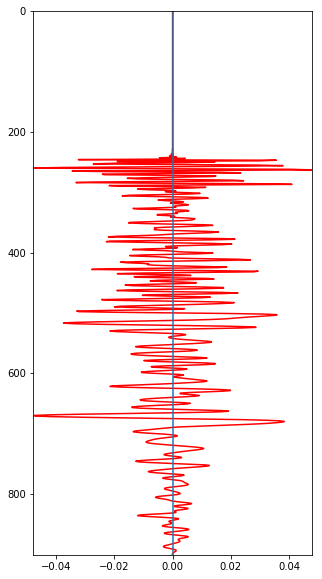

In [13]:
limits = np.amax(np.absolute(trace))
plt.figure(figsize=(5, 10))
plt.plot(trace, range(trace_header['trace_samples']), 'red')
plt.xlim(-limits, limits)
plt.ylim(trace_header['trace_samples'], 0)
plt.axvline(0)

That looks correct.  
Lets do a simple calculation on the trace: mean amplitude.

In [14]:
print("Mean absolute amplitude = {:0.5f}".format(np.mean(np.absolute(trace))))

Mean absolute amplitude = 0.00660


Now lets see about processing more traces.

In [15]:
trace_amp_mean = {}

# Store the first trace result from above
trace_amp_mean[1] = np.mean(np.absolute(trace))
start_time = time.time()

# Iterate through all the remaining traces
current_trace = 0
while True:
    current_trace = current_trace + 1

    trace_header_raw = segy_stream.read(240)
    trace_header = DecodeTraceHeader(trace_header_raw)
    trace_raw = segy_stream.read(trace_header['trace_samples']*4)

    trace = []
    converter = StructIBM32(1)

    for x in range(4, trace_header['trace_samples']*4, 4):
        amplitude = converter.unpack(struct.pack('<L', int(bin(int.from_bytes(trace_raw[x-4:x], byteorder='little', signed=False)), 2)))
        trace.append(amplitude)

    trace_amp_mean[current_trace] = np.mean(np.absolute(trace))

    if current_trace%1000 == 0:
        print("Trace #{} has mean absolute amplitude of {:.5f}, elapse time is {:.2f} seconds.".format(current_trace, trace_amp_mean[current_trace], time.time() - start_time))

    if current_trace > 10000:
        print("Stopping here, this is taking longer than needed.")
        break


Trace #1000 has mean absolute amplitude of 0.01804, elapse time is 3.56 seconds.
Trace #2000 has mean absolute amplitude of 0.01937, elapse time is 7.12 seconds.
Trace #3000 has mean absolute amplitude of 0.01005, elapse time is 10.69 seconds.
Trace #4000 has mean absolute amplitude of 0.01854, elapse time is 14.23 seconds.
Trace #5000 has mean absolute amplitude of 0.02317, elapse time is 17.76 seconds.
Trace #6000 has mean absolute amplitude of 0.01781, elapse time is 21.31 seconds.
Trace #7000 has mean absolute amplitude of 0.02076, elapse time is 24.82 seconds.
Trace #8000 has mean absolute amplitude of 0.02385, elapse time is 28.36 seconds.
Trace #9000 has mean absolute amplitude of 0.02046, elapse time is 31.92 seconds.
Trace #10000 has mean absolute amplitude of 0.02625, elapse time is 35.46 seconds.
Stopping here, this is taking longer than needed.


That is too slow.  Lets clean up the S3 stream and try something else.

In [16]:
segy_stream.close()

### Scale Out

Processing the SEGY file with a single machine is quite slow.  It would take about 18 minutes to complete on this T2.Medium instance.  We could scale up and use a more powerful instance type, but then we are paying per hour, even if we are not using the full compute capacity.  It can quickly start becoming expensive to leave the machines running.  Plus this is not taking advantage of cloud services.

So lets leverage the power of the cloud to scale out and distribute the processing workload with on-demand processing, Lambda!  Lets split this workload and send it to 100 Lambdas that can run in parallel.  We do not need to send any seismic data to Lambda, we will simply tell it where the file is and which bytes to load.

Put in the bucket name you created when deploying the CloudFormation template.

There is a Lambda function that contains the same calculations we performed above called [SegyBatchProcessMeanAmp](https://console.aws.amazon.com/lambda/home?region=us-east-1#/functions/SegyBatchProcessMeanAmp).  If you want, go check it out in the AWS Console.  It was deployed with the CF template.

In [17]:
lambda_name        = "SegyBatchProcessMeanAmp"             # Name of the Lambda function to invoke
results_bucket     = "vavourak-demo-temp"                  # Bucket to use
mean_amp_folder    = "temp-trace-bundles-ST0202-mean-amp"  # Subfolder to place the calculation results
concurrent_lambdas = 100                                   # Number of Lambdas to invoke

In [18]:
# Get S3 object
segy_obj = s3.Object(source_bucket, f"{source_folder}/{source_filename}")

# Define some needed variables based off the above parameters
start_time = time.time()
header_size = 3600
trace_header_size = 240
trace_size = bin_header['samples_per_trace'] * 4
trace_size_with_headers = trace_size + trace_header_size
filesize = segy_obj.content_length
trace_count = int((filesize - 3600) / trace_size_with_headers)
bundle_size = round(trace_count/concurrent_lambdas)

results_file_list = [] # Lets keep track of the output file names, so we can grab them later

lambda_client = boto3.client('lambda')

print(f"Total traces in file: {trace_count}")
print(f"Traces per Lambda for {concurrent_lambdas} concurrency (not rounded): {trace_count/concurrent_lambdas}")
print(f"Traces per Lambda, rounded up: {round(trace_count/concurrent_lambdas+0.5)}")

# Send the trace bundle information over to Lambda
for bundle in range(0, int(trace_count), bundle_size):
    bytes_start = bundle * trace_size_with_headers + header_size
    bytes_stop = (bundle + bundle_size) * trace_size_with_headers + header_size - 1
    #print(f"Bundle traces: {bundle}-{bundle+bundle_size}, bytes: {bytes_start}-{bytes_stop}.")
    
    # Build the message for the Lambda to find the seismic file
    payload = {
        "bucket_in"          : source_bucket,
        "folder_in"          : source_folder,
        "filename_in"        : source_filename,
        "bucket_out"         : results_bucket,
        "folder_out"         : mean_amp_folder,
        "bytes_start"        : bytes_start,
        "bytes_stop"         : bytes_stop,
        "use_custom_lines"   : 0,
        "data_sample_format" : bin_header['data_sample_format']
    }

    # Invoke the Lambda SegyBatchProcessMeanAmp
    response = lambda_client.invoke(FunctionName=lambda_name,
                                    InvocationType='Event',
                                    Payload=json.dumps(payload))
    
    results_file_list.append(f"{mean_amp_folder}/{source_filename}.{bytes_start}-{bytes_stop}.pkl")

print("Done!  Elapse time to gather trace info and send to Lambda: {:0.2f} seconds.  Now waiting for 80 seconds.".format(time.time() - start_time))

time.sleep(80)      # Waiting before carrying on next steps, to allow time for Lambda to finish.

Total traces in file: 232925
Traces per Lambda for 100 concurrency (not rounded): 2329.25
Traces per Lambda, rounded up: 2330
Done!  Elapse time to gather traces and send to Lambda: 6.66 seconds.  Now waiting for 80 seconds.


Great! The trace bundles are all being processed in parallel by Lambda.  It should take about 1 minute to complete instead of 18!  With Lambda, we do not need to provision any resources or have servers waiting with spare compute capacity.  It is all managed in the background by AWS and you only pay for the compute time needed to run the code.  The cost to do the calculation on this 800MB SEGY file is only $0.02.

The Lambdas should be done by now.  Lets load in the results from S3.

In [19]:
s3_client = boto3.client('s3')

trace_mean_amp = []
trace_x = []
trace_y = []
start_time = time.time()

# Iterate through the files
for x in range(0, len(results_file_list)):
    print("Reading file: ", results_file_list[x])
    
    # Get file from S3, convert from Pickle format
    object = s3_client.get_object(Bucket=results_bucket, Key=results_file_list[x])
    serializedObject = object['Body'].read()
    trace_bundle_temp = pickle.loads(serializedObject)
    
    # Split the tuple [1,2,3] into seperate variables for easier use
    for y in range(0, len(trace_bundle_temp)):
        trace_mean_amp.append(trace_bundle_temp[y][0])
        trace_x.append(trace_bundle_temp[y][1])
        trace_y.append(trace_bundle_temp[y][2])

print("Number of traces loaded: {}, elapsed time: {:0.2f} seconds.".format(len(trace_mean_amp), time.time() - start_time))

Reading file:  temp-trace-bundles-ST0202-mean-amp/ST0202R08_PZ_PSDM_FULL_OFFSET_DEPTH.MIG_FIN.POST_STACK.3D.JS-017534.segy.3600-8956275.pkl
Reading file:  temp-trace-bundles-ST0202-mean-amp/ST0202R08_PZ_PSDM_FULL_OFFSET_DEPTH.MIG_FIN.POST_STACK.3D.JS-017534.segy.8956276-17908951.pkl
Reading file:  temp-trace-bundles-ST0202-mean-amp/ST0202R08_PZ_PSDM_FULL_OFFSET_DEPTH.MIG_FIN.POST_STACK.3D.JS-017534.segy.17908952-26861627.pkl
Reading file:  temp-trace-bundles-ST0202-mean-amp/ST0202R08_PZ_PSDM_FULL_OFFSET_DEPTH.MIG_FIN.POST_STACK.3D.JS-017534.segy.26861628-35814303.pkl
Reading file:  temp-trace-bundles-ST0202-mean-amp/ST0202R08_PZ_PSDM_FULL_OFFSET_DEPTH.MIG_FIN.POST_STACK.3D.JS-017534.segy.35814304-44766979.pkl
Reading file:  temp-trace-bundles-ST0202-mean-amp/ST0202R08_PZ_PSDM_FULL_OFFSET_DEPTH.MIG_FIN.POST_STACK.3D.JS-017534.segy.44766980-53719655.pkl
Reading file:  temp-trace-bundles-ST0202-mean-amp/ST0202R08_PZ_PSDM_FULL_OFFSET_DEPTH.MIG_FIN.POST_STACK.3D.JS-017534.segy.53719656-6267

Reading file:  temp-trace-bundles-ST0202-mean-amp/ST0202R08_PZ_PSDM_FULL_OFFSET_DEPTH.MIG_FIN.POST_STACK.3D.JS-017534.segy.546116836-555069511.pkl
Reading file:  temp-trace-bundles-ST0202-mean-amp/ST0202R08_PZ_PSDM_FULL_OFFSET_DEPTH.MIG_FIN.POST_STACK.3D.JS-017534.segy.555069512-564022187.pkl
Reading file:  temp-trace-bundles-ST0202-mean-amp/ST0202R08_PZ_PSDM_FULL_OFFSET_DEPTH.MIG_FIN.POST_STACK.3D.JS-017534.segy.564022188-572974863.pkl
Reading file:  temp-trace-bundles-ST0202-mean-amp/ST0202R08_PZ_PSDM_FULL_OFFSET_DEPTH.MIG_FIN.POST_STACK.3D.JS-017534.segy.572974864-581927539.pkl
Reading file:  temp-trace-bundles-ST0202-mean-amp/ST0202R08_PZ_PSDM_FULL_OFFSET_DEPTH.MIG_FIN.POST_STACK.3D.JS-017534.segy.581927540-590880215.pkl
Reading file:  temp-trace-bundles-ST0202-mean-amp/ST0202R08_PZ_PSDM_FULL_OFFSET_DEPTH.MIG_FIN.POST_STACK.3D.JS-017534.segy.590880216-599832891.pkl
Reading file:  temp-trace-bundles-ST0202-mean-amp/ST0202R08_PZ_PSDM_FULL_OFFSET_DEPTH.MIG_FIN.POST_STACK.3D.JS-017534.

Lets map out the mean amplitudes using a Matplotlib scatter plot.  The Lambda saved the mean amplitude, along with the X and Y coordinates of each trace group for this purpose.

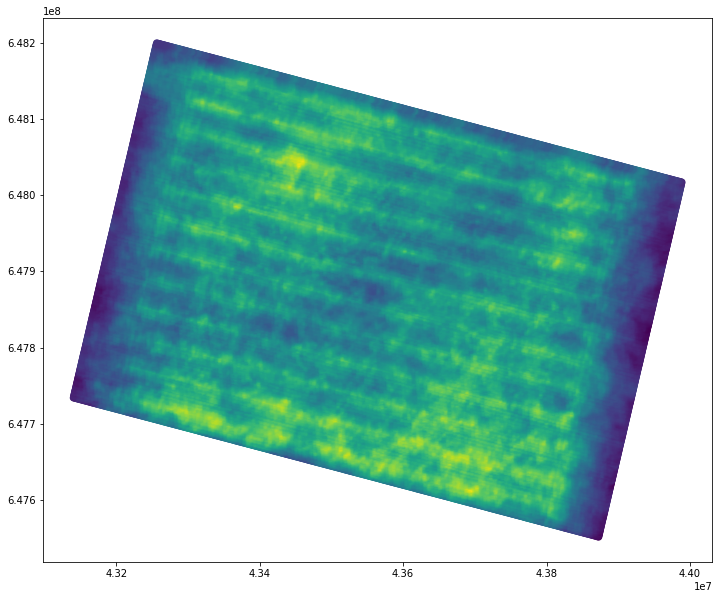

In [23]:
plt.figure(figsize=(12, 10))
plt.scatter(trace_x, trace_y, c=trace_mean_amp)
plt.show()

Looks good!  Seems like there is some banding along the acquisition lines.  Maybe in the future we can make a Lambda function to balance out the variations along each inline/xline.


### Clean-up
Lets clean up the files we created.  We could keep them and catalog them in DynamoDB for future use in a production environment so we do not need rerun calculations, but for today we no longer need them.

In [24]:
for x in range(0, len(results_file_list)):
    _ = s3_client.delete_object(Bucket=results_bucket, Key=results_file_list[x])
    print("Deleting: {}".format(results_file_list[x]))

Deleting: temp-trace-bundles-ST0202-mean-amp/ST0202R08_PZ_PSDM_FULL_OFFSET_DEPTH.MIG_FIN.POST_STACK.3D.JS-017534.segy.3600-8956275.pkl
Deleting: temp-trace-bundles-ST0202-mean-amp/ST0202R08_PZ_PSDM_FULL_OFFSET_DEPTH.MIG_FIN.POST_STACK.3D.JS-017534.segy.8956276-17908951.pkl
Deleting: temp-trace-bundles-ST0202-mean-amp/ST0202R08_PZ_PSDM_FULL_OFFSET_DEPTH.MIG_FIN.POST_STACK.3D.JS-017534.segy.17908952-26861627.pkl
Deleting: temp-trace-bundles-ST0202-mean-amp/ST0202R08_PZ_PSDM_FULL_OFFSET_DEPTH.MIG_FIN.POST_STACK.3D.JS-017534.segy.26861628-35814303.pkl
Deleting: temp-trace-bundles-ST0202-mean-amp/ST0202R08_PZ_PSDM_FULL_OFFSET_DEPTH.MIG_FIN.POST_STACK.3D.JS-017534.segy.35814304-44766979.pkl
Deleting: temp-trace-bundles-ST0202-mean-amp/ST0202R08_PZ_PSDM_FULL_OFFSET_DEPTH.MIG_FIN.POST_STACK.3D.JS-017534.segy.44766980-53719655.pkl
Deleting: temp-trace-bundles-ST0202-mean-amp/ST0202R08_PZ_PSDM_FULL_OFFSET_DEPTH.MIG_FIN.POST_STACK.3D.JS-017534.segy.53719656-62672331.pkl
Deleting: temp-trace-bundl

Deleting: temp-trace-bundles-ST0202-mean-amp/ST0202R08_PZ_PSDM_FULL_OFFSET_DEPTH.MIG_FIN.POST_STACK.3D.JS-017534.segy.572974864-581927539.pkl
Deleting: temp-trace-bundles-ST0202-mean-amp/ST0202R08_PZ_PSDM_FULL_OFFSET_DEPTH.MIG_FIN.POST_STACK.3D.JS-017534.segy.581927540-590880215.pkl
Deleting: temp-trace-bundles-ST0202-mean-amp/ST0202R08_PZ_PSDM_FULL_OFFSET_DEPTH.MIG_FIN.POST_STACK.3D.JS-017534.segy.590880216-599832891.pkl
Deleting: temp-trace-bundles-ST0202-mean-amp/ST0202R08_PZ_PSDM_FULL_OFFSET_DEPTH.MIG_FIN.POST_STACK.3D.JS-017534.segy.599832892-608785567.pkl
Deleting: temp-trace-bundles-ST0202-mean-amp/ST0202R08_PZ_PSDM_FULL_OFFSET_DEPTH.MIG_FIN.POST_STACK.3D.JS-017534.segy.608785568-617738243.pkl
Deleting: temp-trace-bundles-ST0202-mean-amp/ST0202R08_PZ_PSDM_FULL_OFFSET_DEPTH.MIG_FIN.POST_STACK.3D.JS-017534.segy.617738244-626690919.pkl
Deleting: temp-trace-bundles-ST0202-mean-amp/ST0202R08_PZ_PSDM_FULL_OFFSET_DEPTH.MIG_FIN.POST_STACK.3D.JS-017534.segy.626690920-635643595.pkl
Deleti

### Next Steps
Lets scale this project out by 2 orders of magnitude!  Instead of processing only 800MB, which is no real feat of engineering and can be done in-memory even on a cell phone these days, we will process a massive 180GB pre-stack raw seismic file.  